In [18]:
import tensorflow as tf
import os
import cv2
import stat
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# if using gpus to run ANN, allocates only certain amount of GPU memory towards ANN
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
    tf.config.experimental.set_memory_growth(gpu, True)

Found 913 images belonging to 4 classes.


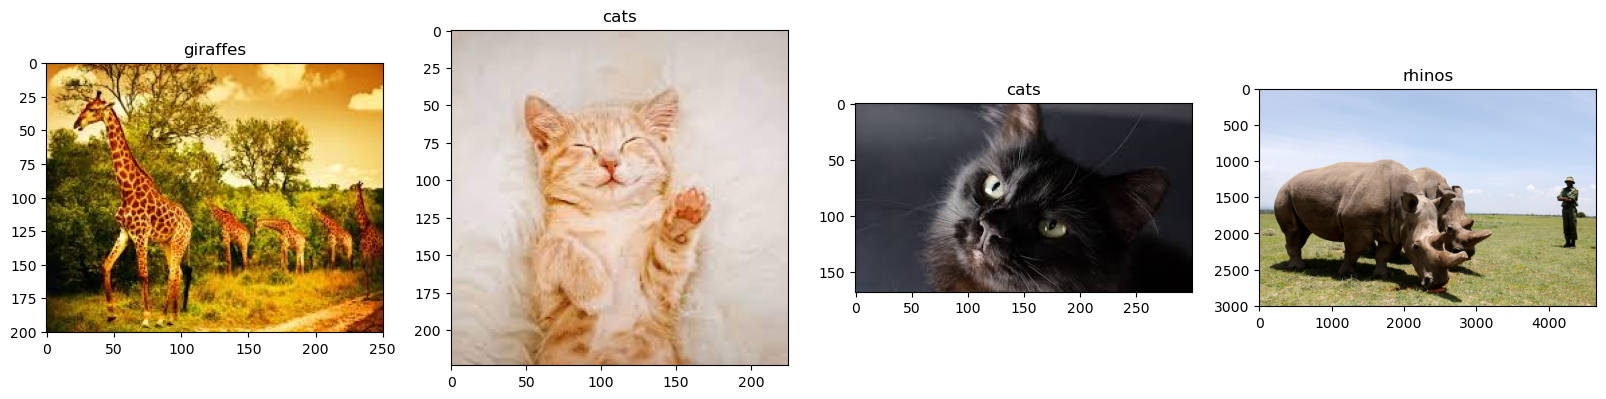

In [9]:
# remove unsupported image files from the directory
img_directory = 'images_general'
for img_class in os.listdir(img_directory):
    for img in os.listdir(os.path.join(img_directory, img_class)):
        img_path = os.path.join(img_directory, img_class, img)
        img_type = imghdr.what(img_path)
        if img_type not in ['jpeg', 'jpg', 'png']:
            print('Removing image {}'.format(img_path))
            os.chmod(img_path, stat.S_IWRITE)
            os.remove(img_path)

# creating a dataset to print 4 random images
image_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
data_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True)

# plots the 4 images
class_labels = list(data_generator.class_indices.keys())
plt.figure(figsize = (20, 20))
for i in range(4):
    random_index = np.random.randint(0, len(data_generator.filenames))
    img_path = os.path.join(img_directory, data_generator.filenames[random_index])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(class_labels[int(data_generator.labels[random_index])])
plt.show()

In [10]:
# ImageDataGenerator creation
image_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# creating training dataset
train_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training')

# creating validation dataset
validation_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation')

Found 732 images belonging to 4 classes.
Found 181 images belonging to 4 classes.


In [11]:
# building the model
input_layer = Input(shape = (256, 256, 3))
conv_1 = Conv2D(16, (3, 3), 1, activation = 'relu')(input_layer)
maxpool_1 = MaxPooling2D()(conv_1)
conv_2 = Conv2D(32, (3, 3), 1, activation = 'relu')(maxpool_1)
maxpool_2 = MaxPooling2D()(conv_2)
conv_3 = Conv2D(16, (3, 3), 1, activation = 'relu')(maxpool_2)
maxpool_3 = MaxPooling2D()(conv_3)
flatten = Flatten()(maxpool_3)
dropout_1 = Dropout(0.5)(flatten)
dense1 = Dense(256, activation = 'relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense1)
output_layer = Dense(len(train_generator.class_indices), activation='softmax')(dropout_2)

model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        462

In [12]:
# training the model
trained_model = model.fit(train_generator, epochs = 20, validation_data = validation_generator)

Epoch 1/20




c:\Users\sid32\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


23/23 [==============================] - 33s 1s/step - loss: 1.5470 - accuracy: 0.3115 - val_loss: 1.3388 - val_accuracy: 0.3260
Epoch 2/20
23/23 [==============================] - 31s 1s/step - loss: 1.2460 - accuracy: 0.4495 - val_loss: 1.0683 - val_accuracy: 0.5856
Epoch 3/20
23/23 [==============================] - 33s 1s/step - loss: 1.0589 - accuracy: 0.5642 - val_loss: 1.0048 - val_accuracy: 0.6022
Epoch 4/20
23/23 [==============================] - 34s 1s/step - loss: 0.8670 - accuracy: 0.6626 - val_loss: 0.8293 - val_accuracy: 0.7017
Epoch 5/20
23/23 [==============================] - 32s 1s/step - loss: 0.7026 - accuracy: 0.7473 - val_loss: 0.6221 - val_accuracy: 0.7845
Epoch 6/20
23/23 [==============================] - 27s 1s/step - loss: 0.5387 - accuracy: 0.8060 - val_loss: 0.6762 - val_accuracy: 0.7845
Epoch 7/20
23/23 [==============================] - 34s 2s/step - loss: 0.4548 - accuracy: 0.8388 - val_loss: 0.6121 - val_accuracy: 0.7845
Epoch 8/20
23/23 [=============

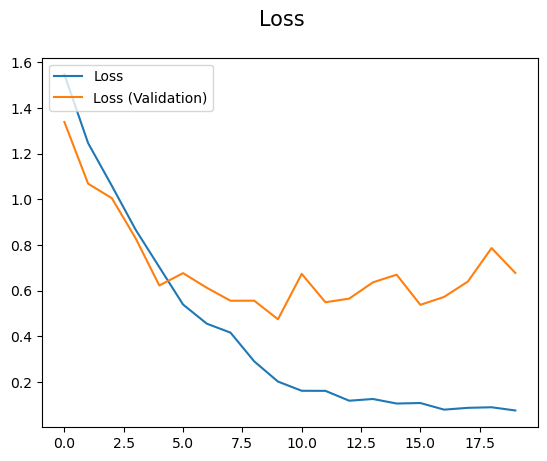

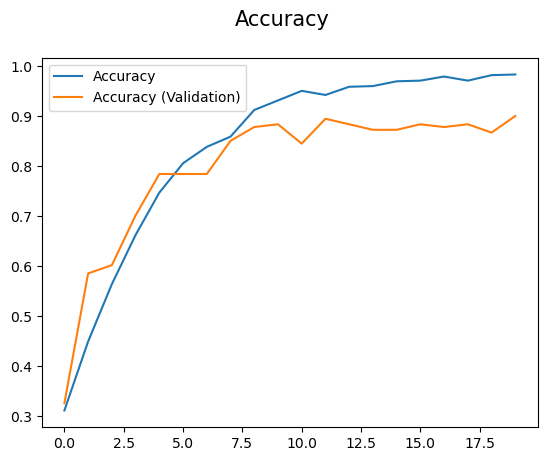

In [23]:
# plotting loss function
fig = plt.figure()
plt.plot(trained_model.history['loss'], label = 'Loss')
plt.plot(trained_model.history['val_loss'], label = 'Loss (Validation)')
fig.suptitle('Loss', fontsize = 15)
plt.legend(loc = "upper left")
plt.show()

# plotting accuracy function
fig = plt.figure()
plt.plot(trained_model.history['accuracy'], label = 'Accuracy')
plt.plot(trained_model.history['val_accuracy'], label = 'Accuracy (Validation)')
fig.suptitle('Accuracy', fontsize = 15)
plt.legend(loc = "upper left")
plt.show()

In [21]:
# evaluating accuracy on the testing set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

6/6 [==============================] - 16s 2s/step - loss: 0.6772 - accuracy: 0.9006
Test Accuracy: 90.06%


1/1 [==============================] - 0s 245ms/step
Predicted class: giraffes


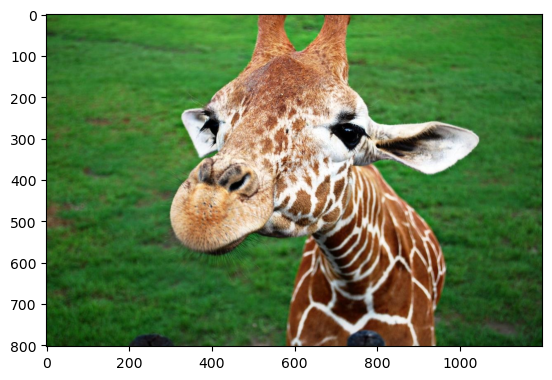

In [15]:
# making predictions on a sample image
test_image_path = "images_general\giraffes\giraffe_baby.jpg"
test_image = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
test_image = tf.image.resize(test_image, (256, 256))
test_image = np.expand_dims(test_image / 255, 0)

predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())

print(f"Predicted class: {class_labels[predicted_class]}")